#### Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Image 
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import config
from copy import deepcopy
import numpy as np
from PIL import Image as pil_im
from PIL import ImageEnhance
from imageio import imwrite
from itertools import product
import matplotlib.pyplot as plt
from fastai.core import Path

from fastai.vision import Image as fast_im
from time import time
import yaml

import dill
import cloudpickle 
dill._dill._reverse_typemap['ClassType'] = type
 

In [10]:
from image_graph import *
from line_bounds import *
from pred_handler import get_top_preds

#### Load models and create image graph

<p style="font-size:16px;color:#FFB5A4">After all of the lines are split and stored in image files, we can split each one into it's individual characters <span style="font-size:13px;">(or sometimes character parts, or multiple characters -- see dataset generation notebook)</span></p>

In [13]:
line_source = Path('../greek_pages/line_images/LAT_RDR_PG2')

lang_model = dill.load(open('../models/latin_lang_model.pkl','rb'))
config.model = load_learner('../models/', 'latin_model.pkl') # model to classify a character component
splitter_model = load_learner('../models/', 'split_model.pkl') # model to split components containing multiple characters

/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute 

<p style="font-size:15px;color:#FFB5A4">For this notebook we will just parse one line, in general each line will be parsed with the following methodology and compiled together into a final text document</p>

In [14]:
line_path = line_source.ls()[0]; line_path

PosixPath('../greek_pages/line_images/LAT_RDR_PG2/line_13.jpeg')

In [15]:
line_path = Path('../greek_pages/line_images/LAT_RDR_PG2/line_2.jpeg')

#### New heading

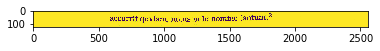

In [21]:
plt.imshow(img)

In [16]:
graph_path = Path('../greek_pages/line_graphs/')
graph_name = line_path.name.replace('.jpg','.txt')

In [17]:
img = get_image_array(line_path)
config.rows, config.cols = img.shape # set config parameters used by the graph processing algorithms

<p style="font-size:16px;color:#FFB5A4">Get a graph representation of the line as well as all the connected components - these represent the individual characters</p>

In [24]:
G.adj[27377]

[27377 -> 29934, 0.0, 27377 -> 29935, 0.0]

In [25]:
img.shape

(121, 2557)

In [19]:
c

{27376: (1806, 1809, 10, 11),
 35046: (1796, 1824, 12, 47),
 96333: (1666, 1777, 28, 68),
 80854: (1579, 1600, 31, 71),
 91536: (2040, 2044, 35, 38),
 95534: (902, 935, 36, 78),
 129076: (1220, 1343, 36, 79),
 93537: (1485, 1494, 36, 44),
 95395: (779, 799, 37, 76),
 95891: (1282, 1285, 37, 39),
 100490: (766, 775, 39, 45),
 100853: (1122, 1175, 39, 79),
 101372: (1601, 1667, 39, 70),
 105726: (889, 897, 40, 48),
 103560: (1278, 1286, 40, 48),
 103611: (1330, 1339, 40, 48),
 106395: (1557, 1560, 41, 44),
 106463: (1626, 1628, 41, 43),
 110544: (586, 617, 42, 72),
 108938: (1533, 1560, 42, 72),
 110580: (617, 644, 43, 73),
 113163: (646, 673, 44, 74),
 121607: (1427, 1533, 44, 75),
 115740: (674, 734, 45, 75),
 120915: (735, 760, 46, 75),
 119030: (1396, 1426, 46, 76),
 123498: (761, 779, 47, 76),
 121556: (1359, 1395, 47, 76),
 123560: (817, 850, 48, 89),
 126144: (851, 904, 48, 78),
 128818: (938, 1019, 48, 79),
 123733: (997, 1000, 48, 50),
 131462: (1054, 1089, 49, 79),
 126395: (10

In [18]:
G = get_graph(graph_path, graph_name, line_path)
c = get_components(G)
with open('../yaml/letter_map_inverse_english.yaml') as f: # get inverse letter-maps to convert from letter code to character
    lm_inv = yaml.load(f)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


#### Define Functions

In [12]:
from split_multi import * 
from image_handling import *

#### Get preds for each component

<p style="font-size:15px;color:#FFB5A4">For each component, predict the letter with the classifier (see training details for info on model)
    <br/><br/>
   Add the top 3 predictions as candidates, the final letter decision will be made by a character level language model</p> 

In [ ]:
s = []
for l in c:
    lb, ub, lbr, ubr = c[l]
    im = get_fast_im(img[lbr:ubr, lb:ub])
    ltrs = [get_top_preds(im, imtype='image', top=3)]
    s.append((lb,ub,ltrs,l))

<p style="font-size:15px;color:#FFB5A4">Quick look at the predictions for the first few characters</p> 

In [ ]:
words = get_words(sorted(s, key=lambda x: x[1]))

In [ ]:
words[0]

<img src="../greek_pages/line_images/LAT_RDR_PG2/line_13.jpeg" style="width: 700px; height=150px;" />

In [ ]:
def get_vertical_neighbor(letter, neighbors):
    left, right = neighbors
    lb, ub, lbr, ubr = zip(c[letter], c[left])
    lb, ub, lbr, ubr = min(lb), max(ub), min(lbr), max(ubr)
    return lb, ub, lbr, ubr

In [ ]:
lb, ub, lbr, ubr =get_vertical_neighbor(102849,(82434,None))

In [ ]:
plt.imshow(img[lbr:ubr, lb:ub])

In [ ]:
lefts, rights = get_sp_ims(img[lbr:ubr, lb:ub].T,.5,2)

In [ ]:
lefts[0]

In [ ]:
get_top_preds(lefts[0],imtype='image',top=3)

In [ ]:
rights[0]

In [ ]:
get_top_preds(rights[0],imtype='image',top=3)

In [ ]:
newll, newlr = get_sp_ims(np.asarray(lefts[0].data[2]*265).T,.5,2)

In [ ]:
newrl, newrr = get_sp_ims(np.asarray(rights[0].data[2]*265).T,.5,2)

In [ ]:
newrl[0]

In [ ]:
newrr[0]

In [ ]:
get_top_preds(newrl[0],imtype='image',top=3)

In [ ]:
get_top_preds(newrr[0],imtype='image',top=3)

word options = 'hil', 'nil', 'h1l', 'n1l', etc

In [ ]:
lang_model.S('h',('**','**')), lang_model.S('h',('**','**'))*.077

In [ ]:
lang_model.S('n',('**','**')), lang_model.S('n',('**','**'))*.0758

In [ ]:
lang_model.S('i',('**','h')), lang_model.S('i',('**','h'))*.002, lang_model.S('i',('**','h'))*.002*.411

In [ ]:
lang_model.S('i',('**','n')), lang_model.S('i',('**','n'))*.004, lang_model.S('i',('**','h'))*.004*.411

In [ ]:
p1 = lang_model.S('l', ('h','i')) * .00012 * .41

In [ ]:
lang_model.S('l', ('h','i'))

In [ ]:
lang_model.S('l', ('n','i'))

In [ ]:
p2 = lang_model.S('l', ('n','i')) * .00024 * .41

In [ ]:
max(p1,p2)

In [ ]:
lang_model.S('i',('**','t'))*.15

lang_model.S('t',('**','t'))*0.7619

lang_model.S('n',('**','**'))*.4

lb, ub, lbr, ubr = c[com]

get_top_preds(get_fast_im(img[lbr:ubr, lb:ub]),imtype='image')

In [ ]:
newl[0]

<p style="font-size:15px;color:#FFB5A4">Now we will create a first attempt at a text version of the line</p> 

<p style="font-size:15px;color:#FFB5A4">For each character, if it is a multi we will split it (see below) and then add each sub-image. If not we just add the letter, using its prediction, its left boundary (pxl number) and the right boundary of the character before. See function def below</p>

In [ ]:
lb, ub, lbr, ubr = c[ltr[-1]]
imwrite('temp.jpg', img[lbr:ubr, lb:ub])
sp_splits, mdl_split = get_mult(Path('temp.jpg'))
l1, l2 = get_best_letters(sp_splits, mdl_split)
[(l1, l2 )]+ [p for p in ltr[2][0] if p[0] != 'multi']

In [ ]:
for w in words:
    w = filter_letters(w)
    print(w)

In [ ]:
max_prob = 0
max_string = ''

In [ ]:
for word in product(ltr_1, ltr_2, ltr_3, ltr_4, ltr_5, ltr_6):
    nword = []
    for w in word:
        if isinstance(w[0], tuple):
            nword.append(w[0])
            nword.append(w[1])
        else:
            nword.append(w)
    word_str = [('**',1),('**',1)] + nword + [('**STOP**',1)]
    i = 2
    prob = 1
    while i < len(word_str):
        try:
            prob *= lang_model.S(word_str[i][0], (word_str[i-2][0], word_str[i-1][0]))*word_str[i][1]
        except:
            prob = 0
        i += 1
    if prob > max_prob:
        max_prob = prob
        max_string = ''.join([w[0] for w in nword])

In [ ]:
l1 = list(product(l1,l2)) + [p for p in ltr[2][0] if p[0] != 'multi']

In [ ]:
# run function definitions below
for i,ltr in enumerate(srted):
    if 'multi' in ltr[2]:
        lb, ub, lbr, ubr = c[ltr[-1]]
        imwrite('temp.jpg', img[lbr:ubr, lb:ub])
        sp_splits, mdl_split = get_mult(Path('temp.jpg'))
        l1, l2 = get_best_letters(sp_splits, mdl_split)
        line += add_letter(l1, srted[max(i-1,0)][1], ltr[0])
        line += add_letter(l2, ltr[0], ltr[0])
    else:
        if ltr[2] != ['noise']:
            line += add_letter(ltr[2], srted[max(i-1,0)][1], ltr[0])

<p style="font-size:15px;color:#FFB5A4">Here is the image of the line, as well as the text generated by the current model and parser. Currently I allow both options for predictions with prob. below .8 separating them by a / character. In a final conversion I would return the argmax. However the future version will use a language model to chose between the top 2 or 3 preds, multiplying the letter probability by the probability of the word generated with that letter. This will most likely not be an issue often in practice since often only one of the options will be an actual word.</p> <br/>
<p style="font-size:15px;color:#FFB5A4">As of now the model has primarily been trained on greek data with only a few english samples, so as I expand that data set the performance on english letters will improve dramatically.</p>

<img src="../greek_pages/line_images/line_1.jpg" style="width: 700px; height=150px;" />

<p style="font-size:15px;color:#FFB5A4">This next function attempts to split an image classified as 'multi' into two sub-characters using two methods:</p>
<ul style="font-size:15px;color:#FFB5A4">
    <li>a shortest path from the estimated split point to the bottom of the image</li>
    <li>a straight line from that point</li></ul>
<br/>
<p style="font-size:15px;color:#FFB5A4">the argmax probabilities of each the letters are multiplied together to get a score, the higher score is chosen as the correct split</p>